In [1]:
# Celda 1: Importaciones y Configuración del Benchmark de Tuning

import subprocess
import time
import pandas as pd
import matplotlib.pyplot as plt
import os
import platform
from tqdm import tqdm
import numpy as np

# --- CONFIGURACIÓN DE LA PRUEBA DE TUNING ---

# 1. Carpeta para guardar los resultados
EXPERIMENT_DIR = "experimentos_opencl_tuning"

# 2. El ejecutable a probar
OPENCL_BINARY = "yee_opencl"

# 3. Tamaño de malla FIJO y grande para esta prueba
GRID_SIZE_FIXED = "500"

# 4. Los "núcleos" a probar: Local Work Sizes (LWS)
#    Estos son los grupos de hilos que lanzaremos.
LOCAL_WORK_SIZES = [8, 12, 14, 16] 

# 5. Número de repeticiones
REPETICIONES = 3

# 6. Detección automática de la carpeta de binarios
ARCHNAME = f"{platform.system()}_{platform.machine()}"
BIN_DIR = f"{ARCHNAME}/bin"

# 7. Nombres de los archivos de salida
OUTPUT_CSV_TUNING = os.path.join(EXPERIMENT_DIR, f"resultados_tuning_lws_grid{GRID_SIZE_FIXED}.csv")
OUTPUT_PNG_TUNING_TIME = os.path.join(EXPERIMENT_DIR, f"rendimiento_tuning_lws_grid{GRID_SIZE_FIXED}.png")
OUTPUT_PNG_TUNING_SPEEDUP = os.path.join(EXPERIMENT_DIR, f"speedup_tuning_lws_grid{GRID_SIZE_FIXED}.png")

# --- PREPARACIÓN DEL ENTORNO ---
os.makedirs(EXPERIMENT_DIR, exist_ok=True)

print("--- Configuración de Tuning OpenCL Cargada ---")
print(f"Directorio: {EXPERIMENT_DIR}")
print(f"Malla Fija: {GRID_SIZE_FIXED}x{GRID_SIZE_FIXED}")
print(f"LWS a probar: {LOCAL_WORK_SIZES}")
print("---------------------------------------------")

--- Configuración de Tuning OpenCL Cargada ---
Directorio: experimentos_opencl_tuning
Malla Fija: 500x500
LWS a probar: [8, 12, 14, 16]
---------------------------------------------


In [2]:
# Celda 2: Recompilar el Ejecutable

print("=== Recompilando el proyecto para asegurar que los cambios están aplicados... ===")
try:
    # Usamos 'make clean' para asegurar una recompilación limpia
    subprocess.run(["make", "clean"], check=True, capture_output=True, text=True)
    subprocess.run(["make"], check=True, capture_output=True, text=True)
    print("¡Compilación completada exitosamente!")
    
    executable_path = os.path.join(BIN_DIR, OPENCL_BINARY)
    if not os.path.exists(executable_path):
        raise FileNotFoundError(f"El ejecutable '{executable_path}' no se encontró.")
    print(f"El ejecutable '{executable_path}' está listo.")
        
except Exception as e:
    print(f"ERROR DURANTE LA COMPILACIÓN: {e}")
    if hasattr(e, 'stderr'): print(f"--- Salida de Error ---\n{e.stderr}\n---------------------")

=== Recompilando el proyecto para asegurar que los cambios están aplicados... ===
¡Compilación completada exitosamente!
El ejecutable 'Linux_x86_64/bin/yee_opencl' está listo.


In [3]:
# Celda 3: Ejecutar el Benchmark de Tuning de LWS

all_results_tuning = []
executable_path = os.path.join(BIN_DIR, OPENCL_BINARY)

if os.path.exists(executable_path):
    total_runs = len(LOCAL_WORK_SIZES) * REPETICIONES
    progress_bar = tqdm(total=total_runs, desc=f"Tuning {OPENCL_BINARY}", unit="run")

    for lws in LOCAL_WORK_SIZES:
        for i in range(REPETICIONES):
            command = [executable_path, "-n", GRID_SIZE_FIXED, "-l", str(lws), "-q"]
            try:
                start_time = time.time()
                subprocess.run(command, check=True, capture_output=True, text=True)
                elapsed = time.time() - start_time
            except subprocess.CalledProcessError as e:
                print(f"\n--- FALLO DETECTADO con LWS={lws} ---\nError: {e.stderr}")
                elapsed = None
            all_results_tuning.append({"lws": lws, "time_s": elapsed})
            progress_bar.update(1)
            progress_bar.set_postfix_str(f"LWS: {lws}x{lws}")

    progress_bar.close()
    print(f"\n¡Benchmark de tuning completado!")
    df_tuning = pd.DataFrame(all_results_tuning).dropna(subset=['time_s'])
else:
    print(f"No se puede ejecutar porque '{executable_path}' no existe.")
    df_tuning = pd.DataFrame()

Tuning yee_opencl: 100%|███████████| 12/12 [00:09<00:00,  1.28run/s, LWS: 16x16]


¡Benchmark de tuning completado!



Tiempos promedio por Local Work Size (LWS):


,lws,time_s
0,8,1.425906
1,12,0.563250
2,14,0.566513
3,16,0.557064



OPTIMIZACIÓN ENCONTRADA: El mejor rendimiento es con LWS = 16x16


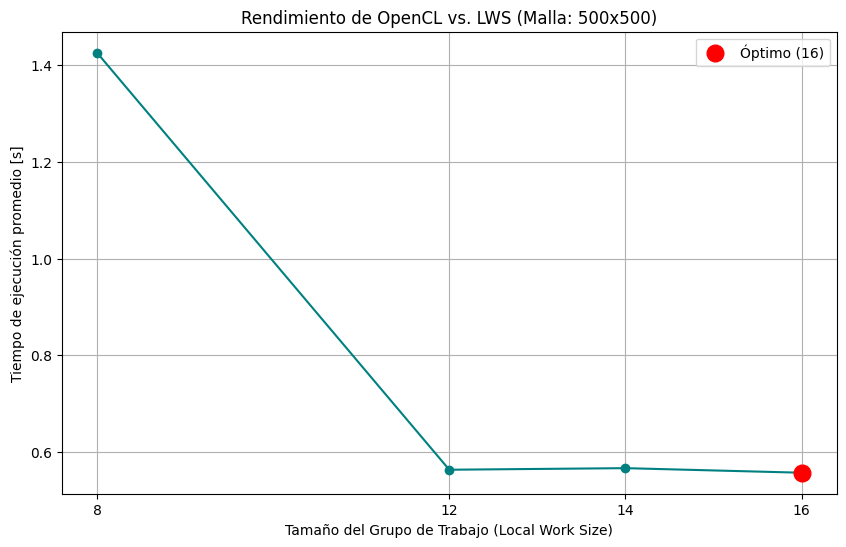

In [4]:
# Celda 4: Gráfica "Tiempo de Ejecución vs LWS"

if 'df_tuning' in locals() and not df_tuning.empty:
    df_tuning.to_csv(OUTPUT_CSV_TUNING, index=False)
    df_mean_tuning = df_tuning.groupby("lws")["time_s"].mean().reset_index()

    print("\nTiempos promedio por Local Work Size (LWS):")
    display(df_mean_tuning)
    
    best_lws_config = df_mean_tuning.loc[df_mean_tuning['time_s'].idxmin()]
    BEST_LWS = int(best_lws_config['lws'])
    print(f"\nOPTIMIZACIÓN ENCONTRADA: El mejor rendimiento es con LWS = {BEST_LWS}x{BEST_LWS}")

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(df_mean_tuning['lws'], df_mean_tuning['time_s'], marker='o', color='teal')
    ax.plot(best_lws_config['lws'], best_lws_config['time_s'], 'o', ms=12, color='red', label=f"Óptimo ({BEST_LWS})")
    ax.set_xlabel("Tamaño del Grupo de Trabajo (Local Work Size)")
    ax.set_ylabel("Tiempo de ejecución promedio [s]")
    ax.set_title(f"Rendimiento de OpenCL vs. LWS (Malla: {GRID_SIZE_FIXED}x{GRID_SIZE_FIXED})")
    ax.set_xticks(LOCAL_WORK_SIZES)
    ax.legend()
    ax.grid(True)
    plt.savefig(OUTPUT_PNG_TUNING_TIME, dpi=300)
    plt.show()
else:
    print("No hay datos de tuning para graficar.")


Tabla de Speedup relativo al LWS más pequeño:


,lws,time_s,speedup
0,8,1.425906,1.000000
1,12,0.563250,2.531569
2,14,0.566513,2.516987
3,16,0.557064,2.559683


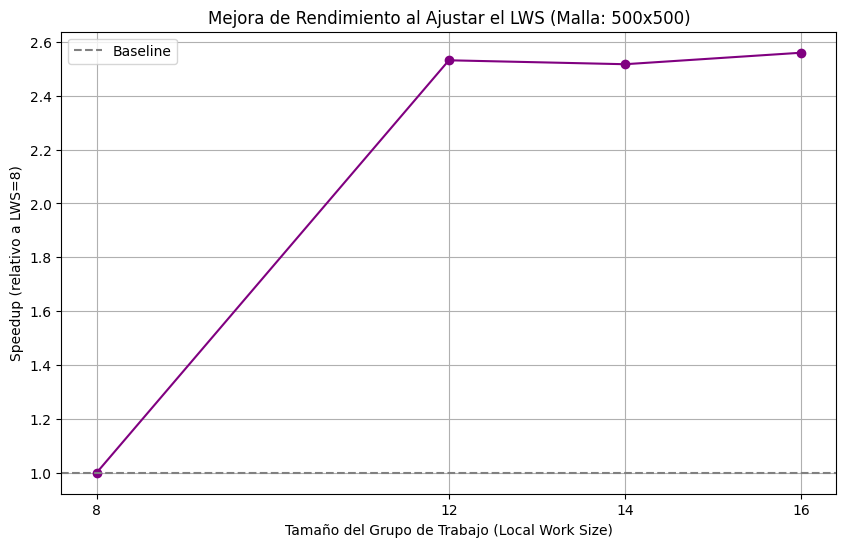

In [5]:
# Celda 5: Gráfica "Speedup vs LWS"

if 'df_mean_tuning' in locals() and not df_mean_tuning.empty:
    # El speedup se calcula relativo a la configuración más simple (el LWS más pequeño)
    baseline_time = df_mean_tuning['time_s'].iloc[0]
    df_mean_tuning['speedup'] = baseline_time / df_mean_tuning['time_s']
    
    print("\nTabla de Speedup relativo al LWS más pequeño:")
    display(df_mean_tuning)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(df_mean_tuning['lws'], df_mean_tuning['speedup'], marker='o', color='purple')
    ax.set_xlabel("Tamaño del Grupo de Trabajo (Local Work Size)")
    ax.set_ylabel(f"Speedup (relativo a LWS={df_mean_tuning['lws'].iloc[0]})")
    ax.set_title(f"Mejora de Rendimiento al Ajustar el LWS (Malla: {GRID_SIZE_FIXED}x{GRID_SIZE_FIXED})")
    ax.axhline(1, color='grey', linestyle='--', label='Baseline')
    ax.set_xticks(LOCAL_WORK_SIZES)
    ax.legend()
    ax.grid(True)
    plt.savefig(OUTPUT_PNG_TUNING_SPEEDUP, dpi=300)
    plt.show()
else:
    print("No hay datos de tuning para calcular el speedup.")


--- INICIANDO BENCHMARK DE ESCALABILIDAD USANDO LWS ÓPTIMO = 16 ---


Escalabilidad con LWS=16: 100%|███████████████████████████████████████████████| 15/15 [00:22<00:00,  1.47s/run]



Resultados de escalabilidad guardados.


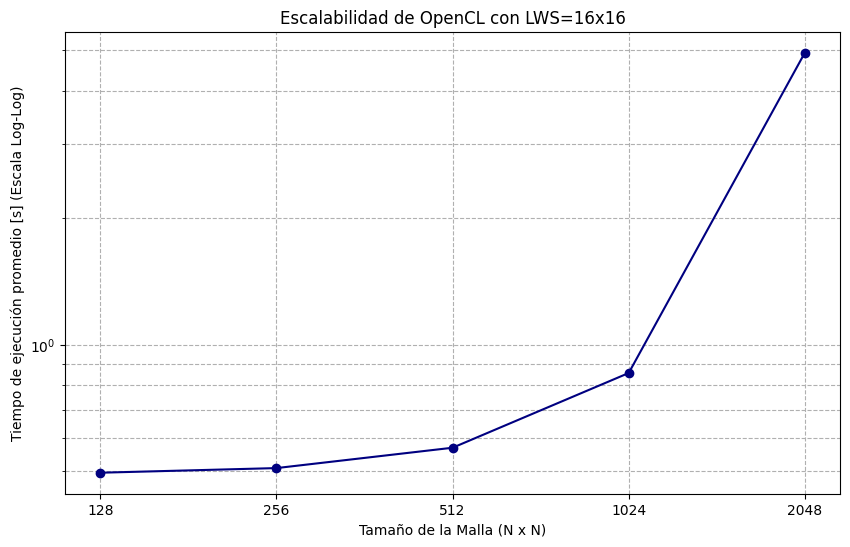

In [6]:
# Celda 6: Benchmark de Escalabilidad (For sobre el tamaño de la malla)

# --- CONFIGURACIÓN DE ESCALABILIDAD ---
if 'BEST_LWS' in locals():
    print(f"\n--- INICIANDO BENCHMARK DE ESCALABILIDAD USANDO LWS ÓPTIMO = {BEST_LWS} ---")
    
    GRID_SIZES_SCALING = [128, 256, 512, 1024, 2048]
    REPETICIONES_SCALING = 3
    OUTPUT_CSV_SCALING = os.path.join(EXPERIMENT_DIR, f"resultados_scaling_lws{BEST_LWS}.csv")
    OUTPUT_PNG_SCALING = os.path.join(EXPERIMENT_DIR, f"rendimiento_scaling_lws{BEST_LWS}.png")

    all_results_scaling = []
    total_runs = len(GRID_SIZES_SCALING) * REPETICIONES_SCALING
    progress_bar = tqdm(total=total_runs, desc=f"Escalabilidad con LWS={BEST_LWS}", unit="run")

    for grid_size in GRID_SIZES_SCALING:
        for i in range(REPETICIONES_SCALING):
            command = [executable_path, "-n", str(grid_size), "-l", str(BEST_LWS), "-q"]
            try:
                start_time = time.time()
                subprocess.run(command, check=True, capture_output=True, text=True)
                elapsed = time.time() - start_time
            except subprocess.CalledProcessError as e:
                print(f"\n--- FALLO DETECTADO en malla {grid_size} ---\nError: {e.stderr}")
                elapsed = None
            all_results_scaling.append({"grid_size": grid_size, "time_s": elapsed})
            progress_bar.update(1)

    progress_bar.close()
    df_scaling = pd.DataFrame(all_results_scaling).dropna(subset=['time_s'])

    if not df_scaling.empty:
        df_scaling_mean = df_scaling.groupby('grid_size')['time_s'].mean().reset_index()
        df_scaling_mean.to_csv(OUTPUT_CSV_SCALING, index=False)
        print("\nResultados de escalabilidad guardados.")
        
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.plot(df_scaling_mean['grid_size'], df_scaling_mean['time_s'], marker='o', color='navy')
        ax.set_xlabel("Tamaño de la Malla (N x N)")
        ax.set_ylabel("Tiempo de ejecución promedio [s] (Escala Log-Log)")
        ax.set_title(f"Escalabilidad de OpenCL con LWS={BEST_LWS}x{BEST_LWS}")
        ax.set_xscale('log', base=2); ax.set_yscale('log')
        ax.set_xticks(GRID_SIZES_SCALING); ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
        ax.grid(True, which="both", linestyle='--')
        plt.savefig(OUTPUT_PNG_SCALING, dpi=300)
        plt.show()
    else:
        print("No se generaron datos de escalabilidad.")
else:
    print("\nNo se puede ejecutar la prueba de escalabilidad porque no se encontró un LWS óptimo en la Parte 1.")